# A typical MIR experiment

This jupyter (https://jupyter.org) python notebook accompanies the article, "On validity of music information retrieval experiments", submitted to TISMIR 2021.

In this experiment, we take features extracted from the BALLROOM dataset and partition them into training and testing sets. We then train and test some basic machine learning models, and measure a variety of figures of merit (FoM). We then look at drawing a variety of conclusions from the results, and test them with further experimentation.

### Import the necessary libraries

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

import librosa
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import rubberband
from sklearn.metrics import plot_confusion_matrix

# Load features extracted from BALLROOM

In [2]:
wav_df = pd.read_pickle('BALLROOMfeatures.pkl')
print(wav_df)

                                        path      class         0         1  \
0                data/Rumba/Media-106011.wav      Rumba -0.002639 -0.045100   
1        data/Rumba/Albums-Latin_Jam4-03.wav      Rumba -0.004676 -0.501934   
2    data/Rumba/Albums-AnaBelen_Veneo-03.wav      Rumba -0.006700  0.380263   
3                data/Rumba/Media-106010.wav      Rumba -0.005836  0.536914   
4                data/Rumba/Media-103817.wav      Rumba  0.000688  0.330394   
..                                       ...        ...       ...       ...   
693          data/Quickstep/Media-105716.wav  Quickstep -0.004833 -0.047262   
694  data/Quickstep/Albums-Chrisanne3-14.wav  Quickstep -0.001751  0.460335   
695          data/Quickstep/Media-105313.wav  Quickstep -0.005414  0.265887   
696  data/Quickstep/Albums-Chrisanne3-15.wav  Quickstep -0.001183  0.611070   
697          data/Quickstep/Media-105717.wav  Quickstep -0.005635  0.252202   

            2         3         4         5        

### The following code was used to extract the features

All recordings are made to have a sample rate of 22050 Hz. The [spectral flux onset strength envelope](http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.onset.onset_strength.html#librosa.onset.onset_strength) is extracted from each recording from the median aggregation over bins of its log-power Mel spectrogram, computed with hop size of 1024 samples (46 ms). The autocorrelation of the envelope is computed and normalized. Then a segment of the autocorrelation relating to lags in \[0.23, 4.14\] s is selected and modeled by a 12th-order autoregressive model. The function returns the 13 coefficients.

In [ ]:
def extractFeatures(df,hop_length=1024,ARorder=12,samplerate=22050,minlag=5,maxlag=90):
    ARparams = []
    for index, row in df.iterrows():
        print(row['path'])
        y, sr = librosa.load(row['path'])
        if sr != samplerate:
            y = librosa.resample(y, sr, samplerate)
        oenv = librosa.onset.onset_strength(y=y, sr=samplerate, aggregate=np.median, \
                                            hop_length=hop_length)
        ac_global = librosa.autocorrelate(oenv)
        ac_global = librosa.util.normalize(ac_global)
        ac_global = ac_global[minlag:maxlag]
        ac_global = ac_global - np.mean(ac_global)
        ARmodel = AutoReg(ac_global,ARorder)
        ARmodel_fit = ARmodel.fit() 
        ARparams.append(ARmodel_fit._params)
    return ARparams

dd = {}
counter = 0
for ff in glob.iglob('BALLROOM/*/*.wav'):
    dd[counter] = {'path':ff, 'class':ff.split('/')[1]}
    counter+=1

wav_df = pd.concat([pd.DataFrame.from_dict(dd,orient='index'), \
                    pd.DataFrame(extractFeatures(wav_df))], axis=1)
print(wav_df)
wav_df.to_pickle('BALLROOMfeatures.pkl')

# Create a random 70/30 split into training and testing sets

In [3]:
wav_train, wav_test = train_test_split(wav_df, test_size=0.3, random_state=123)
targets_train = wav_train['class'].astype('category')
targets_test = wav_test['class'].astype('category')

# Standardize dimensions of training data

In [4]:
wav_train_f = wav_train.drop(['path','class'],axis=1).values
scaler = preprocessing.StandardScaler().fit(wav_train_f)
wav_train_f_scaled = scaler.transform(wav_train_f)
wav_train_f_scaled_df = pd.DataFrame(wav_train_f_scaled, index=wav_train.index, columns=wav_train.columns[2:])

# Standardize dimensions of testing data

In [5]:
wav_test_f = wav_test.drop(['path','class'],axis=1).values
wav_test_f_scaled = scaler.transform(wav_test_f)
wav_test_f_scaled_df = pd.DataFrame(wav_test_f_scaled, index=wav_test.index, columns=wav_test.columns[2:])

# Instantiate ML models

In [6]:
clfLDA = LinearDiscriminantAnalysis()
clfQDA = QuadraticDiscriminantAnalysis()
clf1NN = KNeighborsClassifier(n_neighbors=1,weights='distance')
clf3NN = KNeighborsClassifier(n_neighbors=3,weights='distance')
clf5NN = KNeighborsClassifier(n_neighbors=5,weights='distance')
clf7NN = KNeighborsClassifier(n_neighbors=7,weights='distance')
clf9NN = KNeighborsClassifier(n_neighbors=9,weights='distance')
clfs = [clfLDA, clfQDA, clf1NN, clf3NN, clf5NN, clf7NN, clf9NN]
methodnames = ['LDA','QDA','1NN','3NN','5NN','7NN','9NN']

# Train ML models

In [7]:
for cc in clfs:
    cc.fit(wav_train_f_scaled_df,targets_train)

# Predict labels of testing data

In [8]:
predictions = []
for cc in clfs:
    predictions.append(cc.predict(wav_test_f_scaled_df))

# Compute figures of merit (FoM)

Compute some figures of merit (FoM) for our trained models on the testing dataset.

In [9]:
for pp,nn in zip(predictions,methodnames):
    print(nn,classification_report(targets_test, pp, 
                                   target_names=targets_test.cat.categories))

LDA                precision    recall  f1-score   support

    ChaChaCha       0.86      0.91      0.89        34
         Jive       0.55      0.75      0.63        16
    Quickstep       0.73      0.73      0.73        26
        Rumba       0.65      0.54      0.59        28
        Samba       0.94      0.64      0.76        25
        Tango       0.70      0.86      0.78        22
VienneseWaltz       0.58      0.58      0.58        19
        Waltz       0.68      0.68      0.68        40

     accuracy                           0.71       210
    macro avg       0.71      0.71      0.70       210
 weighted avg       0.73      0.71      0.71       210

QDA                precision    recall  f1-score   support

    ChaChaCha       0.91      0.85      0.88        34
         Jive       0.69      0.69      0.69        16
    Quickstep       0.75      0.81      0.78        26
        Rumba       0.65      0.54      0.59        28
        Samba       0.83      0.80      0.82        2

# FoM for random models

Compute the FoM distributions for a model selecting labels randomly according to the frequencies observed in the training dataset. These can be found in theory, but below we find them empirically. We also show how well each is fit by a univariate Gaussian distribution.

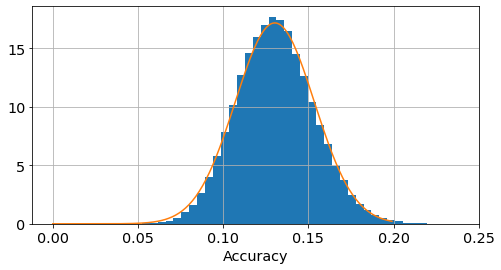

Expected Acc.: 0.130278
Std. Dev. Acc.: 0.02321176483289447


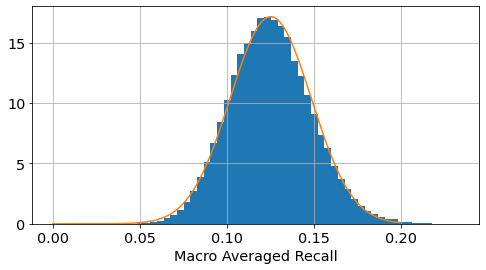

Expected Rec.: 0.12506401319181978
Std. Dev. Rec.: 0.023258475902761425


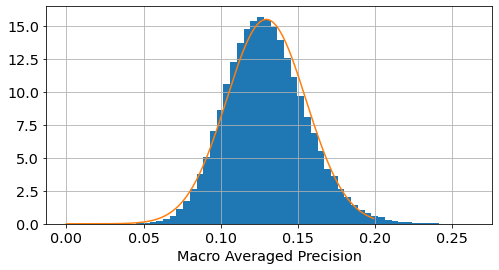

Expected Prec.: 0.12953051657652503
Std. Dev. Prec.: 0.025768593178018297


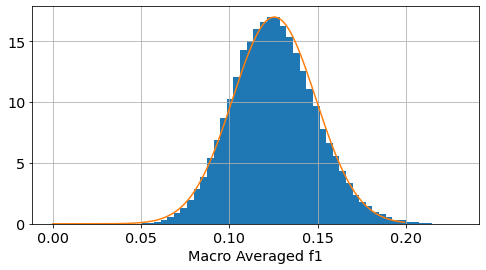

Expected f1: 0.12539002649464145
Std. Dev. f1: 0.023494658714962854


In [13]:
numtrials = 100000
p = (targets_train.value_counts(sort=False)/len(targets_train))
K = len(p)
N = len(targets_test)
Nk = targets_test.value_counts(sort=False)

params = {'legend.fontsize': 'x-large','figure.figsize': (8, 4),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fomk_ACC = []; fomk_RE = []; fomk_PR = []; fomk_f1 = []
for kk in range(K):
    Npredk = np.random.binomial(N,p[kk],numtrials)
    Nkpredk = np.random.binomial(Nk[kk],p[kk],numtrials)
    R = Nkpredk/Nk[kk]
    P = Nkpredk/Npredk
    fomk_ACC.append(Nkpredk)
    fomk_RE.append(R)
    fomk_PR.append(P)
    fomk_f1.append(2*R*P/np.clip(R+P,0.00001,np.inf))

Accuracy_MA = np.sum(fomk_ACC,axis=0)/N
Recall_MA = np.mean(fomk_RE,axis=0)
Precision_MA = np.mean(fomk_PR,axis=0)
f1_MA = np.mean(fomk_f1,axis=0)

EAcc = np.mean(Accuracy_MA); VarAcc = np.var(Accuracy_MA)
ERec = np.mean(Recall_MA); VarRec = np.var(Recall_MA)
EPre = np.mean(Precision_MA); VarPre = np.var(Precision_MA)
Ef1 = np.mean(f1_MA); Varf1 = np.var(f1_MA)

fig, ax = plt.subplots()
plt.hist(Accuracy_MA,bins=41,density=True)
plt.xlabel('Accuracy')
x = np.arange(0,0.2,0.001)
plt.plot(x,sts.norm.pdf(x, EAcc, np.sqrt(VarAcc)))
plt.grid(); plt.show()
print('Expected Acc.:',EAcc)
print('Std. Dev. Acc.:',np.sqrt(VarAcc))

fig, ax = plt.subplots()
plt.hist(Recall_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, ERec, np.sqrt(VarRec)))
plt.xlabel('Macro Averaged Recall')
plt.grid(); plt.show()
print('Expected Rec.:',ERec)
print('Std. Dev. Rec.:',np.sqrt(VarRec))

fig, ax = plt.subplots()
plt.hist(Precision_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, EPre, np.sqrt(VarPre)))
plt.xlabel('Macro Averaged Precision')
plt.grid(); plt.show()
print('Expected Prec.:',EPre)
print('Std. Dev. Prec.:',np.sqrt(VarPre))

fig, ax = plt.subplots()
plt.hist(f1_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, Ef1, np.sqrt(Varf1)))
plt.xlabel('Macro Averaged f1')
plt.grid(); plt.show()
print('Expected f1:',Ef1)
print('Std. Dev. f1:',np.sqrt(Varf1))

FoMfreq = 'freq &'+"${:.2f}".format(EAcc)+"\pm {:.2f}$ &".format(np.sqrt(VarAcc))+ \
      "${:.2f}".format(EPre)+"\pm {:.2f}$ &".format(np.sqrt(VarPre))+ \
      "${:.2f}".format(ERec)+"\pm {:.2f}$ &".format(np.sqrt(VarRec))+ \
      "${:.2f}".format(Ef1)+"\pm {:.2f}$".format(np.sqrt(Varf1))+"\\\\ \\hline"

Compute the FoM distributions for a model selecting labels randomly uniformly. These can be found in theory, but below we find them empirically. It is clear how well each is fit by a univariate Gaussian.

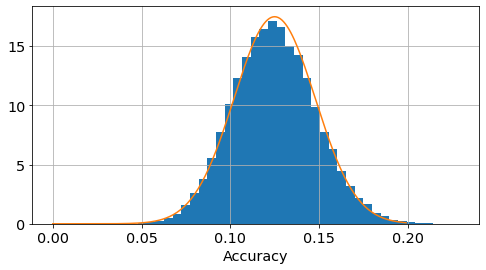

Expected Acc.: 0.12496519047619044
Std. Dev. Acc.: 0.022844218351840712


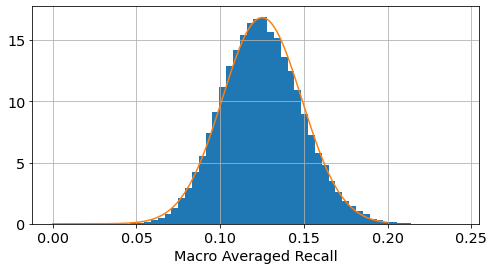

Expected Rec.: 0.12496993055193645
Std. Dev. Rec.: 0.023709916635070667


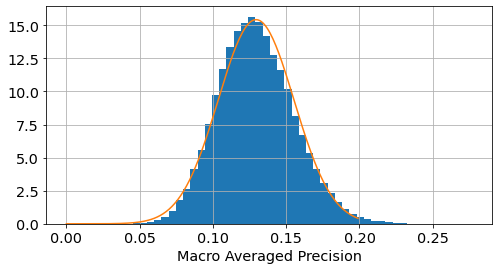

Expected Prec.: 0.12946583126021402
Std. Dev. Prec.: 0.02585840698947887


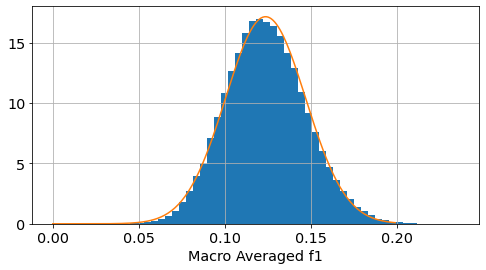

Expected f1: 0.12365734547050054
Std. Dev. f1: 0.023262736259132447


In [14]:
numtrials = 100000

p = np.ones(len(targets_train.value_counts(sort=False)))/len(targets_train.value_counts(sort=False))
K = len(p)
N = len(targets_test)
Nk = targets_test.value_counts(sort=False)

params = {'legend.fontsize': 'x-large','figure.figsize': (8, 4),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fomk_ACC = []; fomk_RE = []; fomk_PR = []; fomk_f1 = []
for kk in range(K):
    Npredk = np.random.binomial(N,p[kk],numtrials)
    Nkpredk = np.random.binomial(Nk[kk],p[kk],numtrials)
    R = Nkpredk/Nk[kk]
    P = Nkpredk/Npredk
    fomk_ACC.append(Nkpredk)
    fomk_RE.append(R)
    fomk_PR.append(P)
    fomk_f1.append(2*R*P/np.clip(R+P,0.00001,np.inf))

Accuracy_MA = np.sum(fomk_ACC,axis=0)/N
Recall_MA = np.mean(fomk_RE,axis=0)
Precision_MA = np.mean(fomk_PR,axis=0)
f1_MA = np.mean(fomk_f1,axis=0)

EAcc = np.mean(Accuracy_MA); VarAcc = np.var(Accuracy_MA)
ERec = np.mean(Recall_MA); VarRec = np.var(Recall_MA)
EPre = np.mean(Precision_MA); VarPre = np.var(Precision_MA)
Ef1 = np.mean(f1_MA); Varf1 = np.var(f1_MA)

fig, ax = plt.subplots()
plt.hist(Accuracy_MA,bins=40,density=True)
plt.xlabel('Accuracy')
x = np.arange(0,0.2,0.001)
plt.plot(x,sts.norm.pdf(x, EAcc, np.sqrt(VarAcc)))
plt.grid(); plt.show()
print('Expected Acc.:',EAcc)
print('Std. Dev. Acc.:',np.sqrt(VarAcc))

fig, ax = plt.subplots()
plt.hist(Recall_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, ERec, np.sqrt(VarRec)))
plt.xlabel('Macro Averaged Recall')
plt.grid(); plt.show()
print('Expected Rec.:',ERec)
print('Std. Dev. Rec.:',np.sqrt(VarRec))

fig, ax = plt.subplots()
plt.hist(Precision_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, EPre, np.sqrt(VarPre)))
plt.xlabel('Macro Averaged Precision')
plt.grid(); plt.show()
print('Expected Prec.:',EPre)
print('Std. Dev. Prec.:',np.sqrt(VarPre))

fig, ax = plt.subplots()
plt.hist(f1_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, Ef1, np.sqrt(Varf1)))
plt.xlabel('Macro Averaged f1')
plt.grid(); plt.show()
print('Expected f1:',Ef1)
print('Std. Dev. f1:',np.sqrt(Varf1))

FoMunif = 'unif &'+"${:.2f}".format(EAcc)+"\pm {:.2f}$ &".format(np.sqrt(VarAcc))+ \
      "${:.2f}".format(EPre)+"\pm {:.2f}$ &".format(np.sqrt(VarPre))+ \
      "${:.2f}".format(ERec)+"\pm {:.2f}$ &".format(np.sqrt(VarRec))+ \
      "${:.2f}".format(Ef1)+"\pm {:.2f}$".format(np.sqrt(Varf1))+"\\\\ \\hline"

Now we compute the FoM for a classifier that just applies the majority label from the training data.

In [15]:
p = (targets_train.value_counts(sort=False)/len(targets_train)) 
maxpclasscat = np.argmax(p)
preds = maxpclasscat*np.ones(len(targets_test))
rep = classification_report(targets_test.cat.codes.values, preds, 
                                   target_names=targets_test.cat.categories,output_dict=True)

FoMmaj = 'maj &'+"${:.2f}$ &".format(rep['accuracy'])+ \
      "${:.2f}$ &".format(rep['macro avg']['precision'])+ \
      "${:.2f}$ &".format(rep['macro avg']['recall'])+ \
      "${:.2f}$".format(rep['macro avg']['f1-score'])+"\\\\ \\hline"


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Create LaTeX table

Write FoM to LaTeX table for paper

In [18]:
print("\\begin{table}[t]\n\\small\\centering")
print("\\begin{tabular}{c|c|c|c|c|}")
print(' & Accuracy & Precision & Recall & f1-score \\\\ \\hline')
for pp,nn in zip(predictions,methodnames):
    rep = classification_report(targets_test, pp, 
                  target_names=targets_test.cat.categories,output_dict=True)
    print(nn,'&',"${:.3f}$ &".format(rep['accuracy']),"${:.3f}$ &".format(rep['macro avg']['precision']),
         "${:.3f}$ &".format(rep['macro avg']['recall']),"${:.3f}$".format(rep['macro avg']['f1-score']),'\\\\ \\hline')
print(FoMunif)
print(FoMfreq)
print(FoMmaj)
print("\\end{tabular}")
print("\\caption{Accuracy, and macro-averaged precision, recall and f1-score observed \
for several models in a testing partition of BALLROOM \cite{Dixon2004}. \
The performance of two models randomly selecting labels are shown in the rows labeled: \
{\\em unif} samples labels uniformly; \
{\\em freq} samples labels according to training data label frequency. \
The last row shows the performance of a model choosing the label most frequent \
in the training data.}")
print("\\label{tab:modelsBALLROOM}\n\\end{table}")

\begin{table}[t]
\small\centering
\begin{tabular}{c|c|c|c|c|}
 & Accuracy & Precision & Recall & f1-score \\ \hline
LDA & $0.714$ & $0.711$ & $0.711$ & $0.703$ \\ \hline
QDA & $0.719$ & $0.715$ & $0.723$ & $0.717$ \\ \hline
1NN & $0.662$ & $0.644$ & $0.635$ & $0.638$ \\ \hline
3NN & $0.681$ & $0.673$ & $0.651$ & $0.656$ \\ \hline
5NN & $0.719$ & $0.699$ & $0.687$ & $0.689$ \\ \hline
7NN & $0.695$ & $0.669$ & $0.656$ & $0.659$ \\ \hline
9NN & $0.700$ & $0.681$ & $0.664$ & $0.668$ \\ \hline
unif &$0.12\pm 0.02$ &$0.13\pm 0.03$ &$0.12\pm 0.02$ &$0.12\pm 0.02$\\ \hline
freq &$0.13\pm 0.02$ &$0.13\pm 0.03$ &$0.13\pm 0.02$ &$0.13\pm 0.02$\\ \hline
maj &$0.16$ &$0.02$ &$0.12$ &$0.03$\\ \hline
\end{tabular}
\caption{Accuracy, and macro-averaged precision, recall and f1-score observed for several models in a testing partition of BALLROOM \cite{Dixon2004}. The performance of two models randomly selecting labels are shown in the rows labeled: {\em unif} samples labels uniformly; {\em freq} sample

We now compute a p-value: the probability of observing a macro-averaged recall at least as big as 0.6 from the model selecting labels randomly with their frequency in the training data. This shows $p < e^{-200}$.

In [19]:
# ERec is the mean of the Gaussian distribution fitting the recall
# VarRec is the variance of the Gaussian distribution fitting the recall
print(ERec)
print(np.sqrt(VarRec))
sts.norm.logcdf(-(0.6-ERec), 0, np.sqrt(VarRec))

0.12496993055193645
0.023709916635070667


-204.62110845911167

# Compute distributions of FoM over 70/30 partitioning

One might want to conclude from the table above that Gaussian modelling
performs better than nearest neighbour modelling with these features 
on 70/30 partitions of BALLROOM. The following empirically finds the variation in accuracy due to the 70/30 partitioning of the BALLROOM. This shows the conclusion lacks validity.

In [20]:
numtrials = 1000

Accuracies = []
Recalls = []
Precisions = []
f1s = []
for ii in range(numtrials):
    wav_train, wav_test = train_test_split(wav_df, test_size=0.3)
    targets_train = wav_train['class'].astype('category')
    targets_test = wav_test['class'].astype('category')

    wav_train_f = wav_train.drop(['path','class'],axis=1).values
    scaler = preprocessing.StandardScaler().fit(wav_train_f)
    wav_train_f_scaled = scaler.transform(wav_train_f)
    wav_train_f_scaled_df = pd.DataFrame(wav_train_f_scaled, index=wav_train.index, columns=wav_train.columns[2:])

    wav_test_f = wav_test.drop(['path','class'],axis=1).values
    wav_test_f_scaled = scaler.transform(wav_test_f)
    wav_test_f_scaled_df = pd.DataFrame(wav_test_f_scaled, index=wav_test.index, columns=wav_test.columns[2:])

    predictions = []
    for cc in clfs:
        cc.fit(wav_train_f_scaled_df,targets_train)
        predictions.append(cc.predict(wav_test_f_scaled_df))

    acc = []
    rec = []
    pre = []
    f1 = []
    for pp in predictions:
        rep = classification_report(targets_test, pp, \
                target_names=targets_test.cat.categories,output_dict=True)
        acc.append(rep['accuracy'])
        rec.append(rep['macro avg']['recall'])
        pre.append(rep['macro avg']['precision'])
        f1.append(rep['macro avg']['f1-score'])
        
    Accuracies.append(acc)
    Recalls.append(rec)
    Precisions.append(pre)
    f1s.append(f1)
    
Accuracies = np.array(Accuracies)
Recalls = np.array(Recalls)
Precisions = np.array(Precisions)
f1s = np.array(f1s)

The histograms of the FoM for the two kinds of models are very similar.

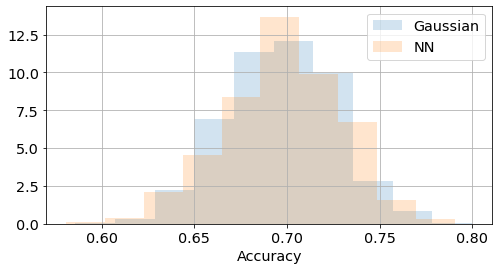

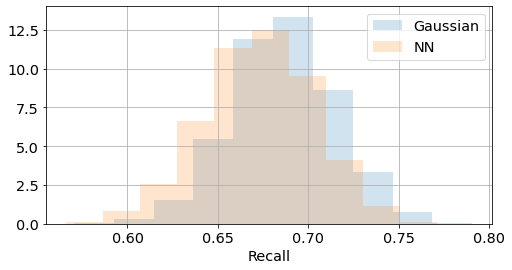

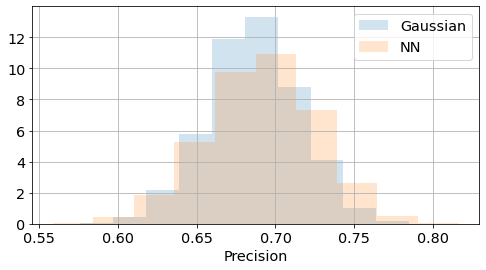

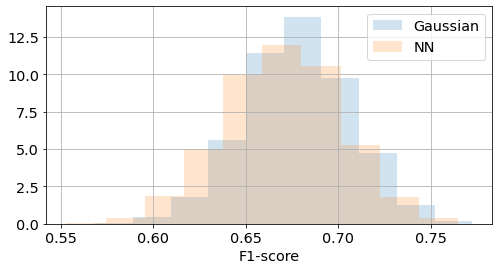

In [21]:
fig, ax = plt.subplots()
plt.hist(np.hstack(Accuracies[:,:2]),bins=10,density=True,alpha=0.2,label='Gaussian')
plt.hist(np.hstack(Accuracies[:,2:]),bins=10,density=True,alpha=0.2,label='NN')
plt.legend()
plt.xlabel('Accuracy')
plt.grid(); plt.show()

fig, ax = plt.subplots()
plt.hist(np.hstack(Recalls[:,:2]),bins=10,density=True,alpha=0.2,label='Gaussian')
plt.hist(np.hstack(Recalls[:,2:]),bins=10,density=True,alpha=0.2,label='NN')
plt.legend()
plt.xlabel('Recall')
plt.grid(); plt.show()

fig, ax = plt.subplots()
plt.hist(np.hstack(Precisions[:,:2]),bins=10,density=True,alpha=0.2,label='Gaussian')
plt.hist(np.hstack(Precisions[:,2:]),bins=10,density=True,alpha=0.2,label='NN')
plt.legend()
plt.xlabel('Precision')
plt.grid(); plt.show()

fig, ax = plt.subplots()
plt.hist(np.hstack(f1s[:,:2]),bins=10,density=True,alpha=0.2,label='Gaussian')
plt.hist(np.hstack(f1s[:,2:]),bins=10,density=True,alpha=0.2,label='NN')
plt.legend()
plt.xlabel('F1-score')
plt.grid(); plt.show()

# Distribution of differences between best FoM

Let's plot histograms of the differences between each FoM of the best Gaussian model and the FoM of the best nearest neighbor model for each partitioning. We see that any differences in performance is swamped by variation due to partitioning. The probability of observing differences less than zero for each FoM (i.e., the best Gaussian model is inferior to best the NN model) is in the range $[0.35,0.7]$.

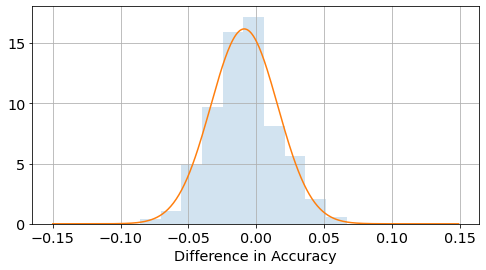

p = 0.6410843899971755


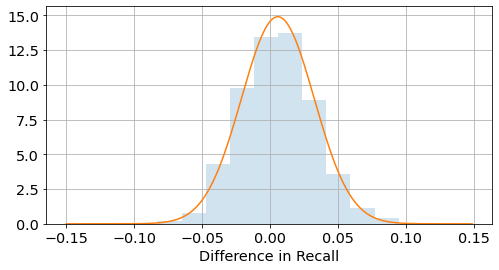

p = 0.4143696179887608


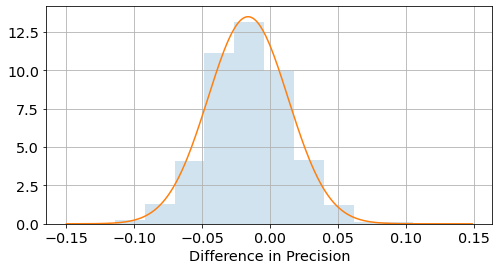

p = 0.7075583805865006


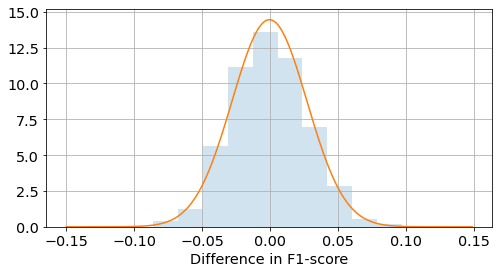

p = 0.5050736307746773


In [22]:
fig, ax = plt.subplots()
S = np.max(Accuracies[:,:2],axis=1)-np.max(Accuracies[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in Accuracy')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

fig, ax = plt.subplots()
S = np.max(Recalls[:,:2],axis=1)-np.max(Recalls[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in Recall')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

fig, ax = plt.subplots()
S = np.max(Precisions[:,:2],axis=1)-np.max(Precisions[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in Precision')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

fig, ax = plt.subplots()
S = np.max(f1s[:,:2],axis=1)-np.max(f1s[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in F1-score')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

What about the FoM difference between the QDA model and that of the worst nearest neighbor model? We see that only for recall might we conclude QDA performs significantly better than the worst nearest neighbor model ($p < 0.05$).

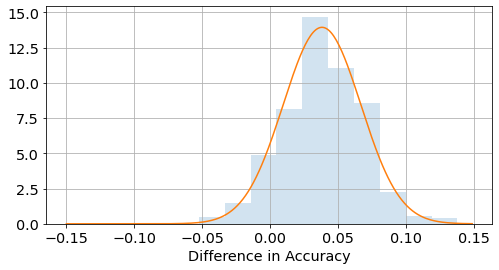

p = 0.09004348615134411


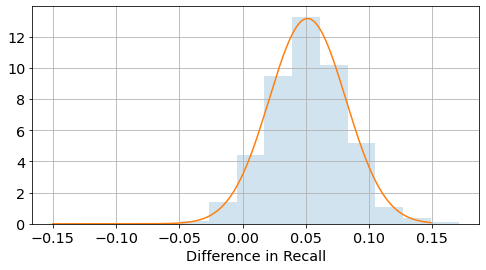

p = 0.045241256926338194


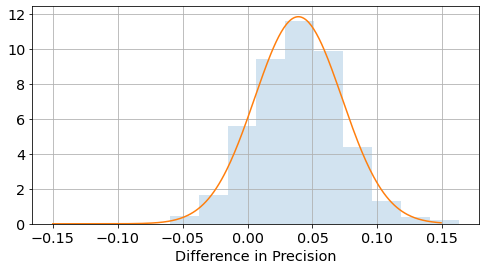

p = 0.12264927559310934


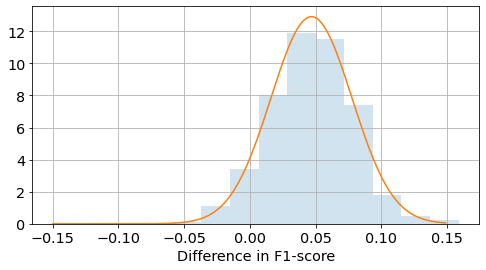

p = 0.06462794478090128


In [23]:
fig, ax = plt.subplots()
S = Accuracies[:,1]-np.min(Accuracies[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in Accuracy')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

fig, ax = plt.subplots()
S = Recalls[:,1]-np.min(Recalls[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in Recall')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

fig, ax = plt.subplots()
S = Precisions[:,1]-np.min(Precisions[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in Precision')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

fig, ax = plt.subplots()
S = f1s[:,1]-np.min(f1s[:,2:],axis=1)
muS = np.mean(S)
stdS = np.sqrt(np.var(S))
plt.hist(S,bins=10,density=True,alpha=0.2)
x = np.arange(-0.15,0.15,0.001)
plt.xlabel('Difference in F1-score')
plt.plot(x,sts.norm.pdf(x, muS, stdS))
plt.grid(); plt.show()
print('p =', sts.norm.cdf(0, muS, stdS))

# Dilation intervention: Questioning Internal Validity

One might conclude from the above that our ML models have learned to recognize 
the rhythms in BALLROOM. Each of their FoM is significantly greater than that expected of a random model (remember $p < e^{-200}$!). This is certainly one explanation consistent with
the performance of our systems, but is it the only one? The internal validity of this conclusion relies on a key assumption: inferring the correct labels of BALLROOM 
can *only* be the result of learning to discriminate between
and identify the rhythms in BALLROOM.
In other words, we must assume that there is no other way to
accurately infer labels in BALLROOM than by perceiving rhythm.

In the following we demonstrate how sensitive our trained models are to tempi, thus casting serious doubt on the above conclusion. We perform relatively minor pitch-preserving time-dilation on all recordings in the testing partition, and then extract the same features and submit them to the trained classifiers.

### This is the code we use to dilate recordings and extract the features

In [ ]:
def extractFeaturesDilatedAudio(df,Dfactor,hop_length=1024,ARorder=12,samplerate=22050,minlag=5,maxlag=90):
    ARparams = []
    for index, row in df.iterrows():
        print(row['path'])
        y, sr = librosa.load(row['path'])
        y = rubberband.stretch(y,rate=sr,ratio=Dfactor)
        if sr != samplerate:
            y = librosa.resample(y, sr, samplerate)
        oenv = librosa.onset.onset_strength(y=y, sr=samplerate, aggregate=np.median, \
                                            hop_length=hop_length)
        ac_global = librosa.autocorrelate(oenv)
        ac_global = librosa.util.normalize(ac_global)
        ac_global = ac_global[minlag:maxlag]
        ac_global = ac_global - np.mean(ac_global)
        ARmodel = AutoReg(ac_global,ARorder)
        ARmodel_fit = ARmodel.fit() 
        ARparams.append(ARmodel_fit._params)
    return ARparams

import rubberband

dd = {}
counter = 0
for ff in glob.iglob('BALLROOM/*/*.wav'):
    dd[counter] = {'path':ff, 'class':ff.split('/')[1]}
    counter+=1

wav_df = pd.DataFrame.from_dict(dd,orient='index')

DFactors = [-15, -10, -8, -6, -4, -3, -2, -1, 0, 1, 2, 3, 4, 6, 8, 10, 15]
for dfactor in DFactors:
    ARparams = extractFeaturesDilatedAudio(wav_df,1+dfactor/100.0)
    wav_df2 = pd.concat([wav_df, pd.DataFrame(ARparams)], axis=1)
    wav_df2.to_pickle('BALLROOMfeatures_dfactor'+str(dfactor)+'.pkl')

Load the original features, create 70/30 partition, scale the data, train the models, and then test on the features extracted from the dilated recordings in the test partition.

In [23]:
wav_df = pd.read_pickle('BALLROOMfeatures.pkl')
wav_train, wav_test = train_test_split(wav_df, test_size=0.3, random_state=123)
testindex = wav_test.index
targets_train = wav_train['class'].astype('category')
targets_test = wav_test['class'].astype('category')
wav_train_f = wav_train.drop(['path','class'],axis=1).values
scaler = preprocessing.StandardScaler().fit(wav_train_f)
wav_train_f_scaled = scaler.transform(wav_train_f)
wav_train_f_scaled_df = pd.DataFrame(wav_train_f_scaled, index=wav_train.index, columns=wav_train.columns[2:])
for cc in clfs:
    cc.fit(wav_train_f_scaled_df,targets_train)

DFactors = [-15, -10, -8, -6, -4, -3, -2, -1, 0, 1, 2, 3, 4, 6, 8, 10, 15]
Accuracies = []
Recalls = []
Precisions = []
f1s = []
for dfactor in DFactors:
    if dfactor == 0:
        wav_df = pd.read_pickle('BALLROOMfeatures.pkl')
    else:
        wav_df = pd.read_pickle('BALLROOMfeatures_dfactor'+str(dfactor)+'.pkl')
    wav_test = wav_df.loc[testindex]
    wav_test_f = wav_test.drop(['path','class'],axis=1).values
    wav_test_f_scaled = scaler.transform(wav_test_f)
    wav_test_f_scaled_df = pd.DataFrame(wav_test_f_scaled, index=wav_test.index, columns=wav_test.columns[2:])
    acc = []
    rec = []
    pre = []
    f1 = []
    for cc in clfs:
        predictions = cc.predict(wav_test_f_scaled_df)
        rep = classification_report(targets_test, predictions, 
                  target_names=targets_test.cat.categories,output_dict=True)
        acc.append(rep['accuracy'])
        rec.append(rep['macro avg']['recall'])
        pre.append(rep['macro avg']['precision'])
        f1.append(rep['macro avg']['f1-score'])
    Accuracies.append(acc)
    Recalls.append(rec)
    Precisions.append(pre)
    f1s.append(f1)
    
Accuracies = np.array(Accuracies)
Recalls = np.array(Recalls)
Precisions = np.array(Precisions)
f1s = np.array(f1s)

# Interaction between FoM and dilation

Plot how each FoM of each model varies as a function of dilation. The grey dashed line is the FoM of a random model that doesn't care about features.

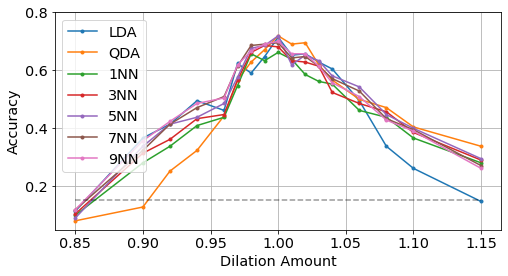

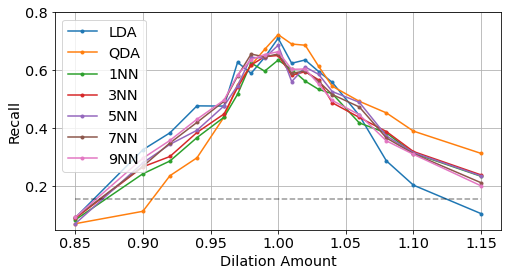

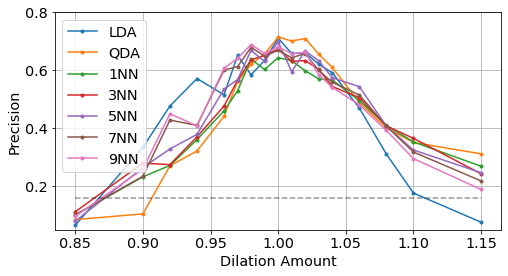

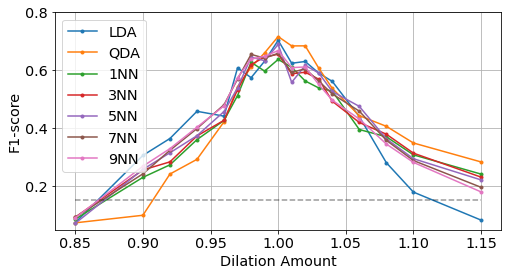

In [32]:
fig, ax = plt.subplots()
h = plt.plot(1+np.array(DFactors)/100,Accuracies,'.-')
plt.legend(h,methodnames)
plt.plot(1+np.array([min(DFactors),max(DFactors)])/100,
         [EAcc,EAcc]+1.96*np.sqrt(VarAcc),'k--',alpha=0.4)
plt.ylabel('Accuracy'); plt.xlabel('Dilation Amount')
plt.ylim([0.05,0.8])
plt.grid(); plt.show()

fig, ax = plt.subplots()
h = plt.plot(1+np.array(DFactors)/100,Recalls,'.-')
plt.legend(h,methodnames)
plt.plot(1+np.array([min(DFactors),max(DFactors)])/100,
         [ERec,ERec]+1.96*np.sqrt(VarRec),'k--',alpha=0.4)
plt.ylabel('Recall'); plt.xlabel('Dilation Amount')
plt.ylim([0.05,0.8])
plt.grid(); plt.show()

fig, ax = plt.subplots()
h = plt.plot(1+np.array(DFactors)/100,Precisions,'.-')
plt.legend(h,methodnames)
plt.plot(1+np.array([min(DFactors),max(DFactors)])/100,
         [EPre,EPre]+1.96*np.sqrt(VarPre),'k--',alpha=0.4)
plt.ylabel('Precision'); plt.xlabel('Dilation Amount')
plt.ylim([0.05,0.8])
plt.grid(); plt.show()

fig, ax = plt.subplots()
h = plt.plot(1+np.array(DFactors)/100,f1s,'.-')
plt.legend(h,methodnames)
plt.plot(1+np.array([min(DFactors),max(DFactors)])/100,
         [Ef1,Ef1]+1.96*np.sqrt(Varf1),'k--',alpha=0.4)
plt.ylabel('F1-score'); plt.xlabel('Dilation Amount')
plt.ylim([0.05,0.8])
plt.grid(); plt.show()

# Questioning External Validity

We might want to conclude from our basic MIR experiment above that our models have learned about music rhythm, not only as it exists in BALLROOM, but in other datasets (generalizing to another population). Let's have a look at how they perform in the [Extended BALLROOM dataset](http://anasynth.ircam.fr/home/media/ExtendedBallroom). This dataset is introduced in Marchand, U. and Peeters, G. (2016). Scale and shift invariant time/frequency representation using auditory statistics: Application to rhythm description. In IEEE Int. Work. Machine Learning for Sig. Proces.

In the below, we extract features from this dataset and see how well our trained models perform. Are the FoM of our trained models significantly better than random?

### This is the code we use to extract the features from extended BALLROOM

In [ ]:
import glob
import pandas as pd
import numpy as np

dd = {}
counter = 0
for ff in glob.iglob('extendedballroom_v1.1/*/*.mp3'):
    dd[counter] = {'path':ff, 'class':ff.split('/')[6]}
    counter+=1

wav_df_ext = pd.DataFrame.from_dict(dd,orient='index')
print(wav_df_ext)

import librosa
from statsmodels.tsa.ar_model import AutoReg

def extractFeatures(df,hop_length=1024,ARorder=12,samplerate=22050,minlag=5,maxlag=90):
    ARparams = []
    for index, row in df.iterrows():
        print(row['path'])
        y, sr = librosa.load(row['path'])
        if sr != samplerate:
            y = librosa.resample(y, sr, samplerate)
        oenv = librosa.onset.onset_strength(y=y, sr=samplerate, aggregate=np.median, \
                                            hop_length=hop_length)
        ac_global = librosa.autocorrelate(oenv)
        ac_global = librosa.util.normalize(ac_global)
        ac_global = ac_global[minlag:maxlag]
        ac_global = ac_global - np.mean(ac_global)
        ARmodel = AutoReg(ac_global,ARorder)
        ARmodel_fit = ARmodel.fit()
        ARparams.append(ARmodel_fit._params)
    return ARparams

ARparams = extractFeatures(wav_df_ext)
wav_df_ext = pd.concat([wav_df_ext, pd.DataFrame(ARparams)], axis=1)
print(wav_df_ext)
wav_df_ext.to_pickle('extendedBALLROOMfeatures.pkl')

# Test our BALLROOM models in Extended BALLROOM

Let's classify all observations in extended BALLROOM.

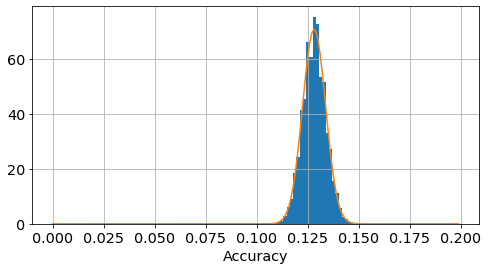

Expected Acc.: 0.12816008034433285
Std. Dev. Acc.: 0.005643527265746665


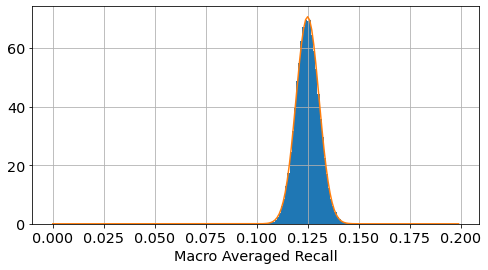

Expected Rec.: 0.12495883881289348
Std. Dev. Rec.: 0.005641477454161076


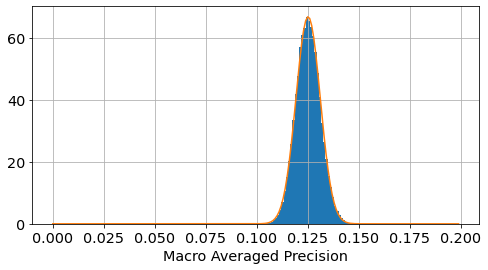

Expected Prec.: 0.12521910569281833
Std. Dev. Prec.: 0.005969819043976891


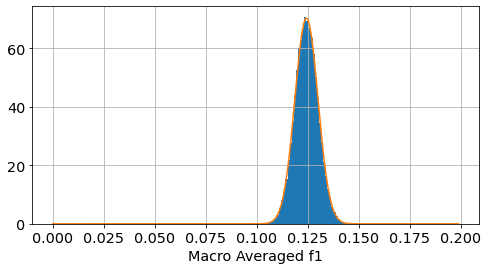

Expected f1: 0.1244073764282894
Std. Dev. f1: 0.005665889036150517


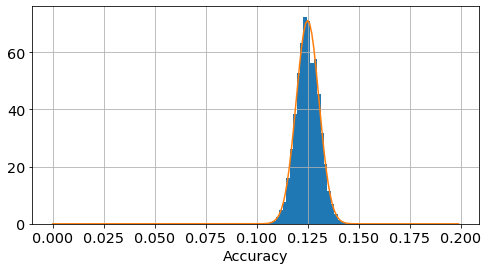

Expected Acc.: 0.12498062553802008
Std. Dev. Acc.: 0.005606911739315293


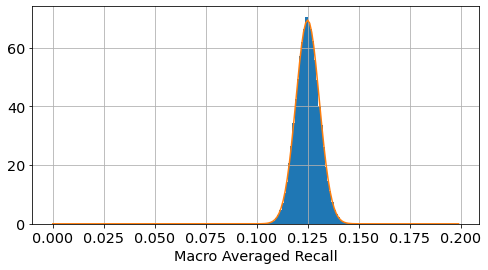

Expected Rec.: 0.12498059661697615
Std. Dev. Rec.: 0.005753623903161548


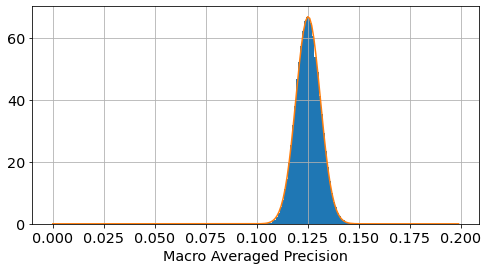

Expected Prec.: 0.12522589994050506
Std. Dev. Prec.: 0.005975682729495615


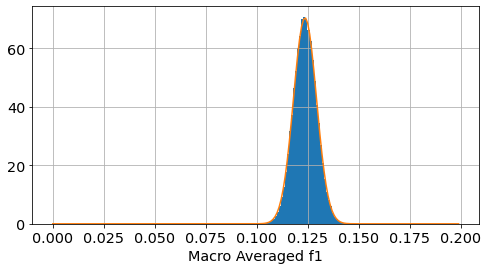

Expected f1: 0.12369055772458692
Std. Dev. f1: 0.005659839766929183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
wav_df = pd.read_pickle('BALLROOMfeatures.pkl')

wav_train, wav_test = train_test_split(wav_df, test_size=0.3, random_state=123)
targets_train = wav_train['class'].astype('category')
wav_train_f = wav_train.drop(['path','class'],axis=1).values
scaler = preprocessing.StandardScaler().fit(wav_train_f)
wav_train_f_scaled = scaler.transform(wav_train_f)
wav_train_f_scaled_df = pd.DataFrame(wav_train_f_scaled, index=wav_train.index, columns=wav_train.columns[2:])

methodnames = ['LDA','QDA','1NN','3NN','5NN','7NN','9NN']
clfs = [clfLDA, clfQDA, clf1NN, clf3NN, clf5NN, clf7NN, clf9NN]
for cc in clfs:
    cc.fit(wav_train_f_scaled_df,targets_train)

wav_test_ext = pd.read_pickle('extendedBALLROOMfeatures.pkl')
targets_test = wav_test_ext['class'].astype('category')
wav_test_f = wav_test_ext.drop(['path','class'],axis=1).values
wav_test_f_scaled = scaler.transform(wav_test_f)
wav_test_f_scaled_df = pd.DataFrame(wav_test_f_scaled, index=wav_test_ext.index, columns=wav_test_ext.columns[2:])

predictions = []
for cc in clfs:
    predictions.append(cc.predict(wav_test_f_scaled_df))
    
numtrials = 100000

p = (targets_train.value_counts(sort=False)/len(targets_train))
K = len(p)
N = len(targets_test)
Nk = targets_test.value_counts(sort=False)

params = {'legend.fontsize': 'x-large','figure.figsize': (8, 4),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fomk_ACC = []; fomk_RE = []; fomk_PR = []; fomk_f1 = []
for kk in range(K):
    Npredk = np.random.binomial(N,p[kk],numtrials)
    Nkpredk = np.random.binomial(Nk[kk],p[kk],numtrials)
    R = Nkpredk/Nk[kk]
    P = Nkpredk/Npredk
    fomk_ACC.append(Nkpredk)
    fomk_RE.append(R)
    fomk_PR.append(P)
    fomk_f1.append(2*R*P/np.clip(R+P,0.00001,np.inf))

Accuracy_MA = np.sum(fomk_ACC,axis=0)/N
Recall_MA = np.mean(fomk_RE,axis=0)
Precision_MA = np.mean(fomk_PR,axis=0)
f1_MA = np.mean(fomk_f1,axis=0)

EAcc = np.mean(Accuracy_MA); VarAcc = np.var(Accuracy_MA)
ERec = np.mean(Recall_MA); VarRec = np.var(Recall_MA)
EPre = np.mean(Precision_MA); VarPre = np.var(Precision_MA)
Ef1 = np.mean(f1_MA); Varf1 = np.var(f1_MA)

fig, ax = plt.subplots()
plt.hist(Accuracy_MA,bins=32,density=True)
plt.xlabel('Accuracy')
x = np.arange(0,0.2,0.001)
plt.plot(x,sts.norm.pdf(x, EAcc, np.sqrt(VarAcc)))
plt.grid(); plt.show()
print('Expected Acc.:',EAcc)
print('Std. Dev. Acc.:',np.sqrt(VarAcc))

fig, ax = plt.subplots()
plt.hist(Recall_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, ERec, np.sqrt(VarRec)))
plt.xlabel('Macro Averaged Recall')
plt.grid(); plt.show()
print('Expected Rec.:',ERec)
print('Std. Dev. Rec.:',np.sqrt(VarRec))

fig, ax = plt.subplots()
plt.hist(Precision_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, EPre, np.sqrt(VarPre)))
plt.xlabel('Macro Averaged Precision')
plt.grid(); plt.show()
print('Expected Prec.:',EPre)
print('Std. Dev. Prec.:',np.sqrt(VarPre))

fig, ax = plt.subplots()
plt.hist(f1_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, Ef1, np.sqrt(Varf1)))
plt.xlabel('Macro Averaged f1')
plt.grid(); plt.show()
print('Expected f1:',Ef1)
print('Std. Dev. f1:',np.sqrt(Varf1))

FoMfreq = 'freq &'+"${:.2f}".format(EAcc)+"\pm {:.2f}$ &".format(np.sqrt(VarAcc))+ \
      "${:.2f}".format(EPre)+"\pm {:.2f}$ &".format(np.sqrt(VarPre))+ \
      "${:.2f}".format(ERec)+"\pm {:.2f}$ &".format(np.sqrt(VarRec))+ \
      "${:.2f}".format(Ef1)+"\pm {:.2f}$".format(np.sqrt(Varf1))+"\\\\ \\hline"

numtrials = 100000

p = np.ones(len(targets_train.value_counts(sort=False)))/len(targets_train.value_counts(sort=False))
K = len(p)
N = len(targets_test)
Nk = targets_test.value_counts(sort=False)

params = {'legend.fontsize': 'x-large','figure.figsize': (8, 4),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fomk_ACC = []; fomk_RE = []; fomk_PR = []; fomk_f1 = []
for kk in range(K):
    Npredk = np.random.binomial(N,p[kk],numtrials)
    Nkpredk = np.random.binomial(Nk[kk],p[kk],numtrials)
    R = Nkpredk/Nk[kk]
    P = Nkpredk/Npredk
    fomk_ACC.append(Nkpredk)
    fomk_RE.append(R)
    fomk_PR.append(P)
    fomk_f1.append(2*R*P/np.clip(R+P,0.00001,np.inf))

Accuracy_MA = np.sum(fomk_ACC,axis=0)/N
Recall_MA = np.mean(fomk_RE,axis=0)
Precision_MA = np.mean(fomk_PR,axis=0)
f1_MA = np.mean(fomk_f1,axis=0)

EAcc = np.mean(Accuracy_MA); VarAcc = np.var(Accuracy_MA)
ERec = np.mean(Recall_MA); VarRec = np.var(Recall_MA)
EPre = np.mean(Precision_MA); VarPre = np.var(Precision_MA)
Ef1 = np.mean(f1_MA); Varf1 = np.var(f1_MA)

fig, ax = plt.subplots()
plt.hist(Accuracy_MA,bins=32,density=True)
plt.xlabel('Accuracy')
x = np.arange(0,0.2,0.001)
plt.plot(x,sts.norm.pdf(x, EAcc, np.sqrt(VarAcc)))
plt.grid(); plt.show()
print('Expected Acc.:',EAcc)
print('Std. Dev. Acc.:',np.sqrt(VarAcc))

fig, ax = plt.subplots()
plt.hist(Recall_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, ERec, np.sqrt(VarRec)))
plt.xlabel('Macro Averaged Recall')
plt.grid(); plt.show()
print('Expected Rec.:',ERec)
print('Std. Dev. Rec.:',np.sqrt(VarRec))

fig, ax = plt.subplots()
plt.hist(Precision_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, EPre, np.sqrt(VarPre)))
plt.xlabel('Macro Averaged Precision')
plt.grid(); plt.show()
print('Expected Prec.:',EPre)
print('Std. Dev. Prec.:',np.sqrt(VarPre))

fig, ax = plt.subplots()
plt.hist(f1_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, Ef1, np.sqrt(Varf1)))
plt.xlabel('Macro Averaged f1')
plt.grid(); plt.show()
print('Expected f1:',Ef1)
print('Std. Dev. f1:',np.sqrt(Varf1))

FoMunif = 'unif &'+"${:.2f}".format(EAcc)+"\pm {:.2f}$ &".format(np.sqrt(VarAcc))+ \
      "${:.2f}".format(EPre)+"\pm {:.2f}$ &".format(np.sqrt(VarPre))+ \
      "${:.2f}".format(ERec)+"\pm {:.2f}$ &".format(np.sqrt(VarRec))+ \
      "${:.2f}".format(Ef1)+"\pm {:.2f}$".format(np.sqrt(Varf1))+"\\\\ \\hline"

p = (targets_train.value_counts(sort=False)/len(targets_train)) 
maxpclasscat = np.argmax(p)
preds = maxpclasscat*np.ones(len(targets_test))
rep = classification_report(targets_test.cat.codes.values, preds, 
                                   target_names=targets_test.cat.categories,output_dict=True)

FoMmaj = 'maj &'+"${:.2f}$ &".format(rep['accuracy'])+ \
      "${:.2f}$ &".format(rep['macro avg']['precision'])+ \
      "${:.2f}$ &".format(rep['macro avg']['recall'])+ \
      "${:.2f}$".format(rep['macro avg']['f1-score'])+"\\\\ \\hline"

In [26]:
print("\\begin{table}[t]\n\\small\\centering")
print("\\begin{tabular}{c|c|c|c|c|}")
print(' & Accuracy & Precision & Recall & f1-score \\\\ \\hline')
for pp,nn in zip(predictions,methodnames):
    rep = classification_report(targets_test, pp, 
                  target_names=targets_test.cat.categories,output_dict=True)
    print(nn,'&',"${:.3f}$ &".format(rep['accuracy']),"${:.3f}$ &".format(rep['macro avg']['precision']),
         "${:.3f}$ &".format(rep['macro avg']['recall']),"${:.3f}$".format(rep['macro avg']['f1-score']),'\\\\ \\hline')
print(FoMunif)
print(FoMfreq)
print(FoMmaj)
print("\\end{tabular}")
print("\\caption{As in Table \\ref{tab:modelsBALLROOM}, and tested in all of X-BALLROOM \\citep{Marchand2016a}.}")
print("\\label{tab:modelsExtendedBALLROOM}\n\\end{table}")

\begin{table}[t]
\small\centering
\begin{tabular}{c|c|c|c|c|}
 & Accuracy & Precision & Recall & f1-score \\ \hline
LDA & $0.659$ & $0.647$ & $0.643$ & $0.643$ \\ \hline
QDA & $0.682$ & $0.678$ & $0.672$ & $0.673$ \\ \hline
1NN & $0.622$ & $0.616$ & $0.602$ & $0.604$ \\ \hline
3NN & $0.636$ & $0.629$ & $0.610$ & $0.613$ \\ \hline
5NN & $0.644$ & $0.643$ & $0.617$ & $0.619$ \\ \hline
7NN & $0.647$ & $0.646$ & $0.619$ & $0.621$ \\ \hline
9NN & $0.645$ & $0.643$ & $0.615$ & $0.618$ \\ \hline
unif &$0.12\pm 0.01$ &$0.13\pm 0.01$ &$0.12\pm 0.01$ &$0.12\pm 0.01$\\ \hline
freq &$0.13\pm 0.01$ &$0.13\pm 0.01$ &$0.12\pm 0.01$ &$0.12\pm 0.01$\\ \hline
maj &$0.13$ &$0.02$ &$0.12$ &$0.03$\\ \hline
\end{tabular}
\caption{As in Table \ref{tab:modelsBALLROOM}, and tested in all of X-BALLROOM \citep{Marchand2016a}.}
\label{tab:modelsExtendedBALLROOM}
\end{table}


# Train and test models in Extended BALLROOM

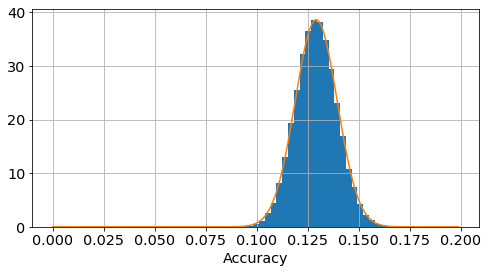

Expected Acc.: 0.12918319311663484
Std. Dev. Acc.: 0.010323166549084868


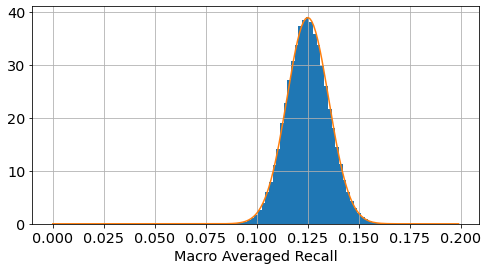

Expected Rec.: 0.12504773871416397
Std. Dev. Rec.: 0.010252585350925833


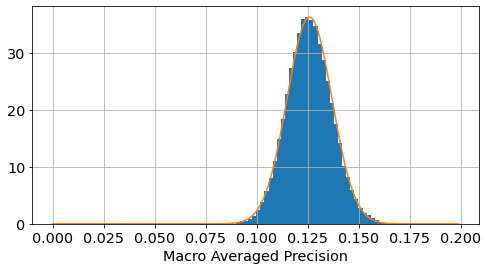

Expected Prec.: 0.12590366348646828
Std. Dev. Prec.: 0.011008092312775742


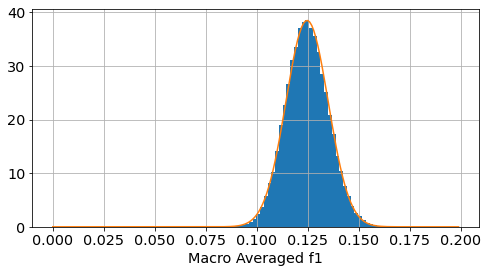

Expected f1: 0.12470932078002751
Std. Dev. f1: 0.010365578882851079


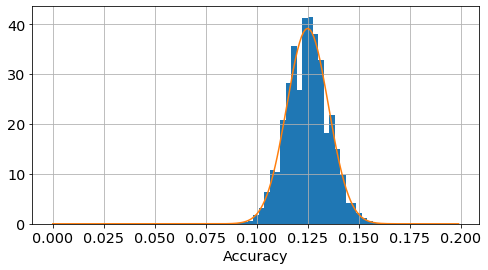

Expected Acc.: 0.1249785277246654
Std. Dev. Acc.: 0.010189471113966371


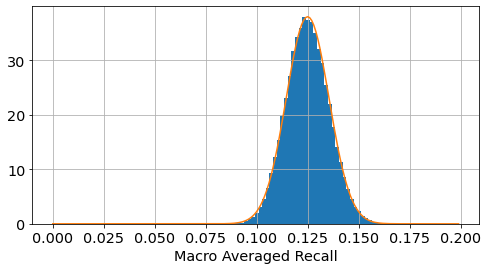

Expected Rec.: 0.12497592696834241
Std. Dev. Rec.: 0.010498986376537942


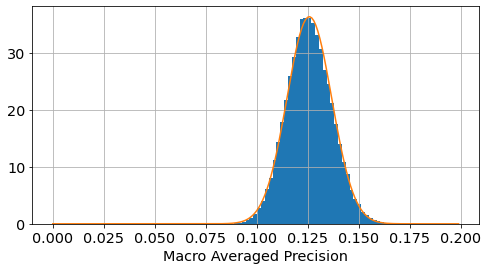

Expected Prec.: 0.12581778050966266
Std. Dev. Prec.: 0.010978656284650055


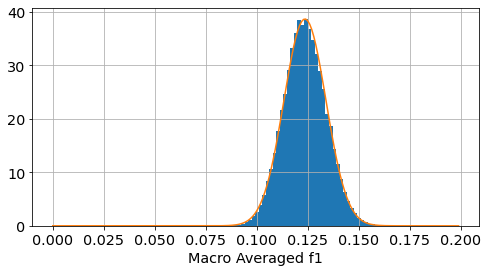

Expected f1: 0.12366794103492597
Std. Dev. f1: 0.010311722915739696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
wav_df = pd.read_pickle('extendedBALLROOMfeatures.pkl')

wav_train, wav_test = train_test_split(wav_df, test_size=0.3, random_state=128)
targets_train = wav_train['class'].astype('category')
wav_train_f = wav_train.drop(['path','class'],axis=1).values
scaler = preprocessing.StandardScaler().fit(wav_train_f)
wav_train_f_scaled = scaler.transform(wav_train_f)
wav_train_f_scaled_df = pd.DataFrame(wav_train_f_scaled, index=wav_train.index, columns=wav_train.columns[2:])

methodnames = ['LDA','QDA','1NN','3NN','5NN','7NN','9NN']
clfs = [clfLDA, clfQDA, clf1NN, clf3NN, clf5NN, clf7NN, clf9NN]
for cc in clfs:
    cc.fit(wav_train_f_scaled_df,targets_train)

targets_test = wav_test['class'].astype('category')

wav_test_f = wav_test.drop(['path','class'],axis=1).values
wav_test_f_scaled = scaler.transform(wav_test_f)
wav_test_f_scaled_df = pd.DataFrame(wav_test_f_scaled, index=wav_test.index, columns=wav_test.columns[2:])

predictions = []
for cc in clfs:
    predictions.append(cc.predict(wav_test_f_scaled_df))
    
numtrials = 100000

p = (targets_train.value_counts(sort=False)/len(targets_train))
K = len(p)
N = len(targets_test)
Nk = targets_test.value_counts(sort=False)

params = {'legend.fontsize': 'x-large','figure.figsize': (8, 4),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fomk_ACC = []; fomk_RE = []; fomk_PR = []; fomk_f1 = []
for kk in range(K):
    Npredk = np.random.binomial(N,p[kk],numtrials)
    Nkpredk = np.random.binomial(Nk[kk],p[kk],numtrials)
    R = Nkpredk/Nk[kk]
    P = Nkpredk/Npredk
    fomk_ACC.append(Nkpredk)
    fomk_RE.append(R)
    fomk_PR.append(P)
    fomk_f1.append(2*R*P/np.clip(R+P,0.00001,np.inf))

Accuracy_MA = np.sum(fomk_ACC,axis=0)/N
Recall_MA = np.mean(fomk_RE,axis=0)
Precision_MA = np.mean(fomk_PR,axis=0)
f1_MA = np.mean(fomk_f1,axis=0)

EAcc = np.mean(Accuracy_MA); VarAcc = np.var(Accuracy_MA)
ERec = np.mean(Recall_MA); VarRec = np.var(Recall_MA)
EPre = np.mean(Precision_MA); VarPre = np.var(Precision_MA)
Ef1 = np.mean(f1_MA); Varf1 = np.var(f1_MA)

fig, ax = plt.subplots()
plt.hist(Accuracy_MA,bins=32,density=True)
plt.xlabel('Accuracy')
x = np.arange(0,0.2,0.001)
plt.plot(x,sts.norm.pdf(x, EAcc, np.sqrt(VarAcc)))
plt.grid(); plt.show()
print('Expected Acc.:',EAcc)
print('Std. Dev. Acc.:',np.sqrt(VarAcc))

fig, ax = plt.subplots()
plt.hist(Recall_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, ERec, np.sqrt(VarRec)))
plt.xlabel('Macro Averaged Recall')
plt.grid(); plt.show()
print('Expected Rec.:',ERec)
print('Std. Dev. Rec.:',np.sqrt(VarRec))

fig, ax = plt.subplots()
plt.hist(Precision_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, EPre, np.sqrt(VarPre)))
plt.xlabel('Macro Averaged Precision')
plt.grid(); plt.show()
print('Expected Prec.:',EPre)
print('Std. Dev. Prec.:',np.sqrt(VarPre))

fig, ax = plt.subplots()
plt.hist(f1_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, Ef1, np.sqrt(Varf1)))
plt.xlabel('Macro Averaged f1')
plt.grid(); plt.show()
print('Expected f1:',Ef1)
print('Std. Dev. f1:',np.sqrt(Varf1))

FoMfreq = 'freq &'+"${:.2f}".format(EAcc)+"\pm {:.2f}$ &".format(np.sqrt(VarAcc))+ \
      "${:.2f}".format(EPre)+"\pm {:.2f}$ &".format(np.sqrt(VarPre))+ \
      "${:.2f}".format(ERec)+"\pm {:.2f}$ &".format(np.sqrt(VarRec))+ \
      "${:.2f}".format(Ef1)+"\pm {:.2f}$".format(np.sqrt(Varf1))+"\\\\ \\hline"

numtrials = 100000

p = np.ones(len(targets_train.value_counts(sort=False)))/len(targets_train.value_counts(sort=False))
K = len(p)
N = len(targets_test)
Nk = targets_test.value_counts(sort=False)

params = {'legend.fontsize': 'x-large','figure.figsize': (8, 4),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fomk_ACC = []; fomk_RE = []; fomk_PR = []; fomk_f1 = []
for kk in range(K):
    Npredk = np.random.binomial(N,p[kk],numtrials)
    Nkpredk = np.random.binomial(Nk[kk],p[kk],numtrials)
    R = Nkpredk/Nk[kk]
    P = Nkpredk/Npredk
    fomk_ACC.append(Nkpredk)
    fomk_RE.append(R)
    fomk_PR.append(P)
    fomk_f1.append(2*R*P/np.clip(R+P,0.00001,np.inf))

Accuracy_MA = np.sum(fomk_ACC,axis=0)/N
Recall_MA = np.mean(fomk_RE,axis=0)
Precision_MA = np.mean(fomk_PR,axis=0)
f1_MA = np.mean(fomk_f1,axis=0)

EAcc = np.mean(Accuracy_MA); VarAcc = np.var(Accuracy_MA)
ERec = np.mean(Recall_MA); VarRec = np.var(Recall_MA)
EPre = np.mean(Precision_MA); VarPre = np.var(Precision_MA)
Ef1 = np.mean(f1_MA); Varf1 = np.var(f1_MA)

fig, ax = plt.subplots()
plt.hist(Accuracy_MA,bins=32,density=True)
plt.xlabel('Accuracy')
x = np.arange(0,0.2,0.001)
plt.plot(x,sts.norm.pdf(x, EAcc, np.sqrt(VarAcc)))
plt.grid(); plt.show()
print('Expected Acc.:',EAcc)
print('Std. Dev. Acc.:',np.sqrt(VarAcc))

fig, ax = plt.subplots()
plt.hist(Recall_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, ERec, np.sqrt(VarRec)))
plt.xlabel('Macro Averaged Recall')
plt.grid(); plt.show()
print('Expected Rec.:',ERec)
print('Std. Dev. Rec.:',np.sqrt(VarRec))

fig, ax = plt.subplots()
plt.hist(Precision_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, EPre, np.sqrt(VarPre)))
plt.xlabel('Macro Averaged Precision')
plt.grid(); plt.show()
print('Expected Prec.:',EPre)
print('Std. Dev. Prec.:',np.sqrt(VarPre))

fig, ax = plt.subplots()
plt.hist(f1_MA,bins=50,density=True)
plt.plot(x,sts.norm.pdf(x, Ef1, np.sqrt(Varf1)))
plt.xlabel('Macro Averaged f1')
plt.grid(); plt.show()
print('Expected f1:',Ef1)
print('Std. Dev. f1:',np.sqrt(Varf1))

FoMunif = 'unif &'+"${:.2f}".format(EAcc)+"\pm {:.2f}$ &".format(np.sqrt(VarAcc))+ \
      "${:.2f}".format(EPre)+"\pm {:.2f}$ &".format(np.sqrt(VarPre))+ \
      "${:.2f}".format(ERec)+"\pm {:.2f}$ &".format(np.sqrt(VarRec))+ \
      "${:.2f}".format(Ef1)+"\pm {:.2f}$".format(np.sqrt(Varf1))+"\\\\ \\hline"

p = (targets_train.value_counts(sort=False)/len(targets_train)) 
maxpclasscat = np.argmax(p)
preds = maxpclasscat*np.ones(len(targets_test))
rep = classification_report(targets_test.cat.codes.values, preds, 
                                   target_names=targets_test.cat.categories,output_dict=True)

FoMmaj = 'maj &'+"${:.2f}$ &".format(rep['accuracy'])+ \
      "${:.2f}$ &".format(rep['macro avg']['precision'])+ \
      "${:.2f}$ &".format(rep['macro avg']['recall'])+ \
      "${:.2f}$".format(rep['macro avg']['f1-score'])+"\\\\ \\hline"

In [28]:
print("\\begin{table}[t]\n\\small\\centering")
print("\\begin{tabular}{c|c|c|c|c|}")
print('Mod & Accuracy & Precision & Recall & f1-score \\\\ \\hline')
for pp,nn in zip(predictions,methodnames):
    rep = classification_report(targets_test, pp, 
                  target_names=targets_test.cat.categories,output_dict=True)
    print(nn,'&',"${:.3f}$ &".format(rep['accuracy']),"${:.3f}$ &".format(rep['macro avg']['precision']),
         "${:.3f}$ &".format(rep['macro avg']['recall']),"${:.3f}$".format(rep['macro avg']['f1-score']),'\\\\ \\hline')
print(FoMunif)
print(FoMfreq)
print(FoMmaj)
print("\\end{tabular}")
print("\\caption{As in Table \\ref{tab:modelsBALLROOM}, but models trained and tested in X-BALLROOM\\citep{Marchand2016a}.}")
print("\\label{tab:modelsExtendedBALLROOM2}\n\\end{table}")

\begin{table}[t]
\small\centering
\begin{tabular}{c|c|c|c|c|}
Mod & Accuracy & Precision & Recall & f1-score \\ \hline
LDA & $0.726$ & $0.721$ & $0.722$ & $0.717$ \\ \hline
QDA & $0.763$ & $0.764$ & $0.773$ & $0.758$ \\ \hline
1NN & $0.702$ & $0.691$ & $0.693$ & $0.690$ \\ \hline
3NN & $0.741$ & $0.731$ & $0.727$ & $0.727$ \\ \hline
5NN & $0.750$ & $0.744$ & $0.736$ & $0.738$ \\ \hline
7NN & $0.753$ & $0.746$ & $0.736$ & $0.738$ \\ \hline
9NN & $0.751$ & $0.746$ & $0.734$ & $0.737$ \\ \hline
unif &$0.12\pm 0.01$ &$0.13\pm 0.01$ &$0.12\pm 0.01$ &$0.12\pm 0.01$\\ \hline
freq &$0.13\pm 0.01$ &$0.13\pm 0.01$ &$0.13\pm 0.01$ &$0.12\pm 0.01$\\ \hline
maj &$0.13$ &$0.02$ &$0.12$ &$0.03$\\ \hline
\end{tabular}
\caption{As in Table \ref{tab:modelsBALLROOM}, but models trained in BALLROOM and tested in all of X-BALLROOM \citep{Marchand2016a}.}
\label{tab:modelsExtendedBALLROOM2}
\end{table}
